In [ ]:
# S-LIME Explainability Notebook for Fine-Tuned Transformer Models (e.g., PuoBERTa)


# ===============================
# INSTALL DEPENDENCIES
# ===============================
!pip install transformers torch lime --quiet

# ===============================
# IMPORTS
# ===============================
import torch
import torch.nn.functional as F  # Import F
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
from transformers import RobertaTokenizer, RobertaForSequenceClassification


# ===============================
# LOAD MODEL & TOKENIZER
# ===============================
model_path = "/path/to/your/fine-tuned/model"  # ✅ Update this e.g mopatik/PuoBERTa-offensive-detection-v1

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.eval() # put the model in evaluation mode!!

# ===============================
# DEFINE PREDICT_PROBA FUNCTION
# ===============================

def predict_proba(texts, batch_size=32):
    probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        with torch.no_grad():
            outputs = model(**inputs)
            batch_probs = F.softmax(outputs.logits, dim=1).detach().cpu().numpy()
        probs.extend(batch_probs)
    return np.array(probs)

# ===============================
# APPLY S-LIME WITH MULTIPLE SEEDS
# ===============================
sample_text = "chelete e jelwe ke senokwane wena"  # Replace with your own Setswana offensive sample
seeds = [42, 0, 13, 77, 99] # seeds for reproducibility.
token_contributions = {}

for seed in seeds:
    np.random.seed(seed)
    explainer = LimeTextExplainer(class_names=["Non-offensive", "Offensive"], random_state=seed)
    explanation = explainer.explain_instance(sample_text, predict_proba, num_features=5, top_labels=1)
    label_index = explanation.top_labels[0]

    for token, weight in explanation.as_list(label=label_index):
        if token not in token_contributions:
            token_contributions[token] = []
        token_contributions[token].append(weight)

# ===============================
# CONSISTENCY ANALYSIS TABLE
# ===============================
df = pd.DataFrame([
    (token, np.mean(w), np.std(w), w) for token, w in token_contributions.items()
], columns=["Token", "Mean Attribution", "Std Dev", "All Seeds"])

df.sort_values("Mean Attribution", ascending=False).reset_index(drop=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.7 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

,Token,Mean Attribution,Std Dev,All Seeds
0,a,0.097096,0.004740,"[0.09563985701716374, 0.09928032947993541, 0.0..."
1,le,0.084957,0.003799,"[0.08471193737631409, 0.08468101918659653, 0.0..."
2,segofatse,0.065196,0.003368,"[0.0635754746830421, 0.06822243307403682, 0.06..."
3,Modimo,-0.018397,0.001034,"[-0.017299026579586426, -0.018468921759942185,..."


from matplotlib import pyplot as plt
_df_0['Mean Attribution'].plot(kind='hist', bins=20, title='Mean Attribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Std Dev'].plot(kind='hist', bins=20, title='Std Dev')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Token').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Mean Attribution', y='Std Dev', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Mean Attribution'].plot(kind='line', figsize=(8, 4), title='Mean Attribution')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Std Dev'].plot(kind='line', figsize=(8, 4), title='Std Dev')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Token'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='Mean Attribution', y='Token', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Token'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Std Dev', y='Token', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

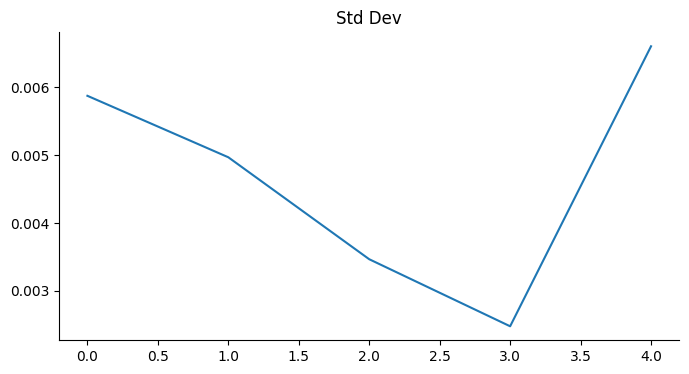

In [ ]:
from matplotlib import pyplot as plt
_df_5['Std Dev'].plot(kind='line', figsize=(8, 4), title='Std Dev')
plt.gca().spines[['top', 'right']].set_visible(False)

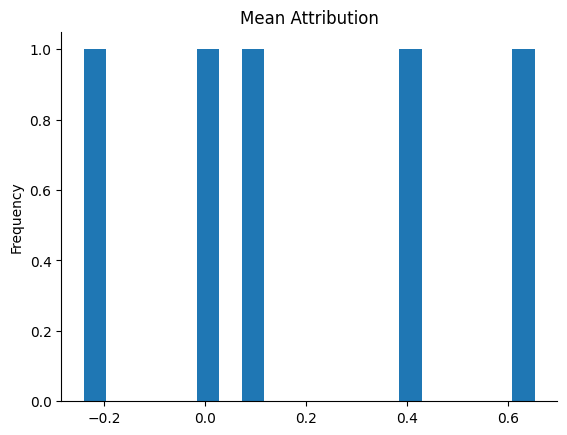

In [ ]:
from matplotlib import pyplot as plt
_df_0['Mean Attribution'].plot(kind='hist', bins=20, title='Mean Attribution')
plt.gca().spines[['top', 'right',]].set_visible(False)